# Gradient-PCA Feature Extraction

Implementation of the Gradient-PCA algorithm for extracting texture features from RGB images.

## Import Required Libraries

In [1]:
import numpy as np
from scipy import ndimage
from typing import Tuple

## Gradient-PCA Feature Extraction Algorithm

This implementation follows the algorithm described in the paper, extracting three texture features:
- **ρ (rho)**: Anisotropy - measures directional variation
- **E**: Energy - measures gradient magnitude
- **κ (kappa)**: Coherence - measures alignment of gradients

In [2]:
def gradient_pca_features(image: np.ndarray) -> Tuple[float, float, float]:
    """
    Extract Gradient-PCA features from an RGB image.
    
    Parameters
    ----------
    image : np.ndarray
        RGB image of shape (H, W, 3) with values in range [0, 255]
        
    Returns
    -------
    Tuple[float, float, float]
        (rho, E, kappa) - Anisotropy, Energy, and Coherence features
    """
    # Step 1: Luminance Conversion
    # L = 0.2126*R + 0.7152*G + 0.0722*B
    luminance = (
        0.2126 * image[:, :, 0] + 
        0.7152 * image[:, :, 1] + 
        0.0722 * image[:, :, 2]
    )
    
    # Step 2-3: Gradient Computation using Sobel operators
    gradient_x = ndimage.sobel(luminance, axis=1)  # Horizontal gradient
    gradient_y = ndimage.sobel(luminance, axis=0)  # Vertical gradient
    
    # Step 4: Flatten to Matrix
    # Stack flattened gradients to create matrix M of shape (2, N)
    # where N = H * W
    matrix = np.vstack([
        gradient_x.flatten(),
        gradient_y.flatten()
    ])
    
    # Step 5: Compute Covariance
    # C = (1/N) * M * M^T
    covariance = (1 / matrix.shape[1]) * np.dot(matrix, matrix.T)
    
    # Step 6: Eigendecomposition
    # Get eigenvalues (λ₁ ≥ λ₂) and sort in descending order
    eigenvalues = np.linalg.eigvalsh(covariance)
    eigenvalues = np.sort(eigenvalues)[::-1]  # Sort descending
    
    lambda_1, lambda_2 = eigenvalues[0], eigenvalues[1]
    
    # Step 7: Extract Features
    # Anisotropy: ρ = λ₁/λ₂
    rho = lambda_1 / lambda_2 if lambda_2 != 0 else 0.0
    
    # Energy: E = λ₁ + λ₂
    energy = lambda_1 + lambda_2
    
    # Coherence: κ = [(λ₁ - λ₂)/(λ₁ + λ₂)]²
    denominator = lambda_1 + lambda_2
    kappa = ((lambda_1 - lambda_2) / denominator) ** 2 if denominator != 0 else 0.0
    
    return rho, energy, kappa

## Example Usage

Let's test the algorithm with a sample image.

Gradient-PCA Features:
  Anisotropy (ρ): 1.0064
  Energy (E):     73889.8492
  Coherence (κ):  0.0000


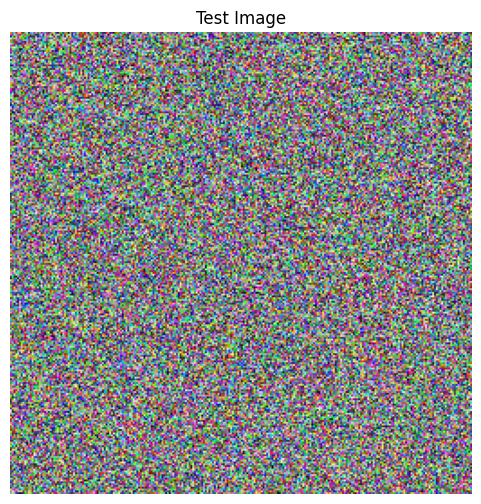

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Load a sample image (replace with your actual image path)
# For demonstration, we'll create a synthetic test image
test_image = np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8)

# Extract features
rho, energy, kappa = gradient_pca_features(test_image)

print(f"Gradient-PCA Features:")
print(f"  Anisotropy (ρ): {rho:.4f}")
print(f"  Energy (E):     {energy:.4f}")
print(f"  Coherence (κ):  {kappa:.4f}")

# Visualize the test image
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title("Test Image")
plt.axis('off')
plt.show()

## Batch Processing Function

Function to extract features from multiple images.

In [4]:
def extract_features_from_dataset(image_paths: list) -> np.ndarray:
    """
    Extract Gradient-PCA features from multiple images.
    
    Parameters
    ----------
    image_paths : list
        List of image file paths
        
    Returns
    -------
    np.ndarray
        Feature matrix of shape (n_images, 3) where each row is (rho, E, kappa)
    """
    features = []
    
    for path in image_paths:
        try:
            # Load image
            img = np.array(Image.open(path))
            
            # Ensure RGB format
            if len(img.shape) == 2:  # Grayscale
                img = np.stack([img] * 3, axis=-1)
            elif img.shape[2] == 4:  # RGBA
                img = img[:, :, :3]
            
            # Extract features
            rho, energy, kappa = gradient_pca_features(img)
            features.append([rho, energy, kappa])
            
        except Exception as e:
            print(f"Error processing {path}: {e}")
            features.append([np.nan, np.nan, np.nan])
    
    return np.array(features)

## Testing on Real Images

Testing the algorithm on 3 sample images from the test_data folder.

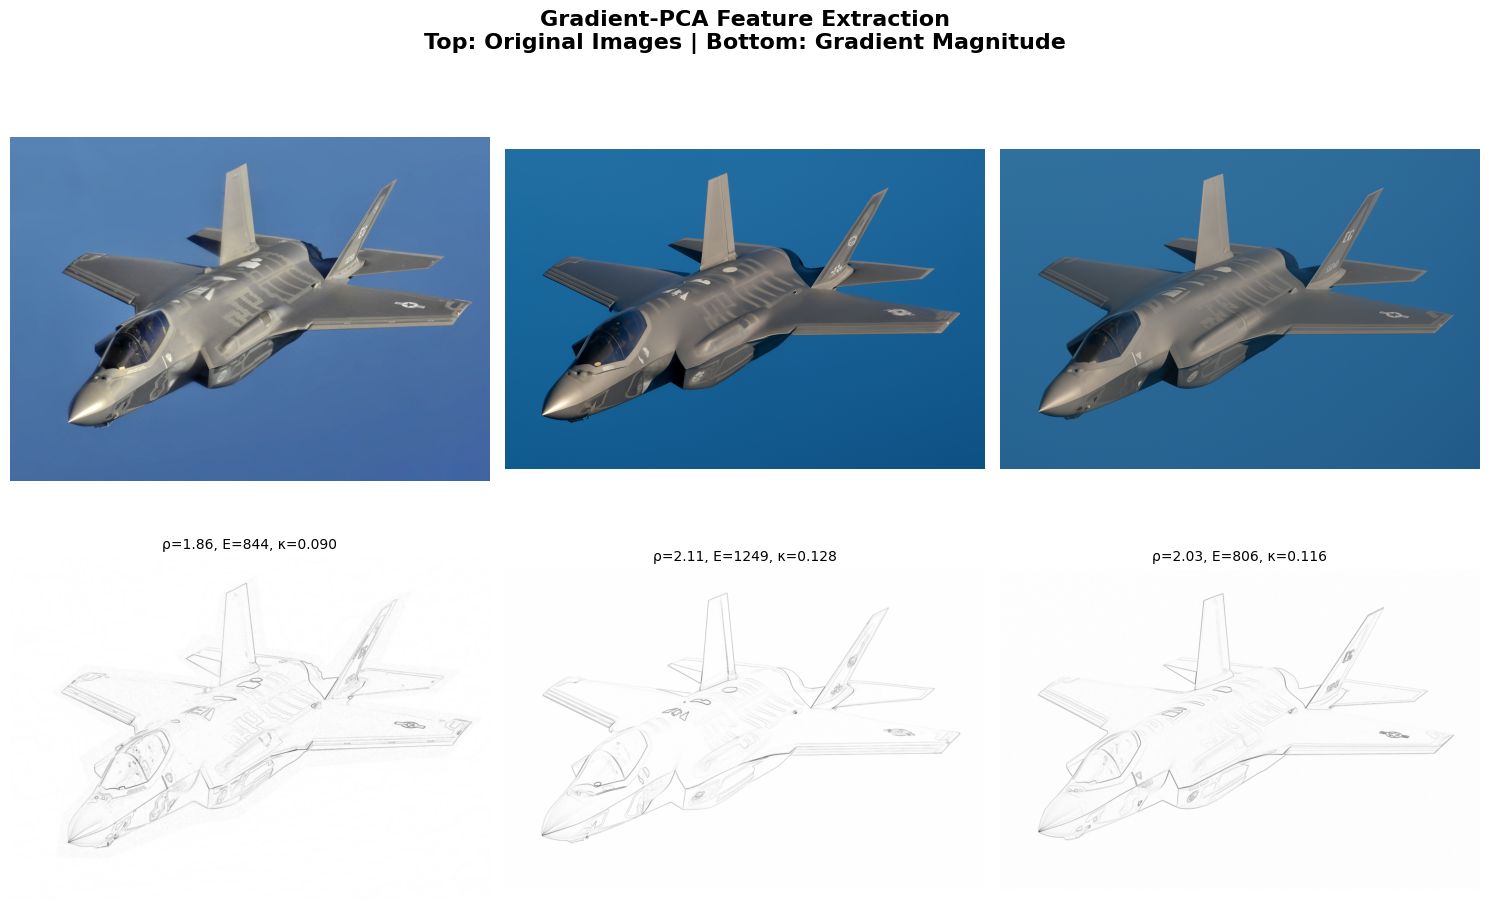


GRADIENT-PCA FEATURE EXTRACTION RESULTS

f35.jpg             
  Anisotropy (ρ):       1.8583
  Energy (E):           844.37
  Coherence (κ):      0.090169

f35_chatgpt2.png    
  Anisotropy (ρ):       2.1117
  Energy (E):          1249.42
  Coherence (κ):      0.127632

f35_chatgpt3.png    
  Anisotropy (ρ):       2.0322
  Energy (E):           805.80
  Coherence (κ):      0.115886


In [13]:
import os

# Define test image paths
test_images = [
    'test_data/f35.jpg',
    'test_data/f35_chatgpt2.png',
    'test_data/f35_chatgpt3.png',
]

# Process each image and visualize
results = []
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, img_path in enumerate(test_images):
    # Load image
    img = np.array(Image.open(img_path))
    
    # Handle RGBA images
    if img.shape[2] == 4:
        img = img[:, :, :3]
    
    # Step 1: Luminance Conversion
    luminance = (
        0.2126 * img[:, :, 0] + 
        0.7152 * img[:, :, 1] + 
        0.0722 * img[:, :, 2]
    )
    
    # Step 2-3: Gradient Computation
    gradient_x = ndimage.sobel(luminance, axis=1)
    gradient_y = ndimage.sobel(luminance, axis=0)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Extract features
    rho, energy, kappa = gradient_pca_features(img)
    
    # Determine label
    basename = os.path.basename(img_path)
    
    results.append({
        'image': basename,
        'anisotropy': rho,
        'energy': energy,
        'coherence': kappa
    })
    
    # Top row: Original images
    axes[0, idx].imshow(img)
    axes[0, idx].axis('off')
    
    # Bottom row: Gradient visualization (inverted colors - white gradients on gray background)
    axes[1, idx].imshow(gradient_magnitude, cmap='gray_r')  # '_r' inverts the colormap
    axes[1, idx].set_title(f"ρ={rho:.2f}, E={energy:.0f}, κ={kappa:.3f}", fontsize=10)
    axes[1, idx].axis('off')

plt.suptitle('Gradient-PCA Feature Extraction\nTop: Original Images | Bottom: Gradient Magnitude', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*70)
print("GRADIENT-PCA FEATURE EXTRACTION RESULTS")
print("="*70)
for result in results:
    print(f"\n{result['image']:20s}")
    print(f"  Anisotropy (ρ): {result['anisotropy']:12.4f}")
    print(f"  Energy (E):     {result['energy']:12.2f}")
    print(f"  Coherence (κ):  {result['coherence']:12.6f}")
print("="*70)